In [1]:
import ray
import os
import time
from ray import tune
from pyhdfs import HdfsClient
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost_ray import RayDMatrix, RayParams, train, RayXGBRFClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import pickle
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score, f1_score, classification_report


In [2]:
ray.shutdown()
ray.init()

2022-11-25 20:13:05,487	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.6
Ray version:,2.1.0
Dashboard:,http://127.0.0.1:8265


In [3]:
nodes = ["127.0.0.1"]
client = HdfsClient(hosts=nodes, user_name="bigdata2022-VirtualBox")
df=pd.read_csv(client.open("hdfs://localhost:9870/user/bigdata2022/datasets/big_data_project/australian_rain_dataset.csv"))

In [4]:
print(df.head())
seed=42

   Unnamed: 0  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0           0     13.4     22.9       0.6          4.7       8.5   
1           1      7.4     25.1       0.0          4.7       8.5   
2           2     12.9     25.7       0.0          4.7       8.5   
3           3      9.2     28.0       0.0          4.7       8.5   
4           4     17.5     32.3       1.0          4.7       8.5   

   WindGustSpeed  WindSpeed9am  WindSpeed3pm  Humidity9am  ...  Pressure3pm  \
0           44.0          20.0          24.0         71.0  ...       1007.1   
1           44.0           4.0          22.0         44.0  ...       1007.8   
2           46.0          19.0          26.0         38.0  ...       1008.7   
3           24.0          11.0           9.0         45.0  ...       1012.8   
4           41.0           7.0          20.0         82.0  ...       1006.0   

   RainToday  RainTomorrow  Month  WindGustDir_N  WindGustDir_S  \
0          0             0     12              0 

In [5]:
X = df.drop(['RainTomorrow'], axis=1)
t = df['RainTomorrow']

In [6]:
X_train, X_test, t_train, t_test = train_test_split(X, t, train_size=0.75)
print(t_test.head())

51368    0
9196     0
73267    1
72543    0
39380    0
Name: RainTomorrow, dtype: int64


In [7]:
start_time=time.time()

In [8]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
ray_param = RayParams(
                      num_actors=4,
                      cpus_per_actor=1
                   ) 

In [11]:
model = RayXGBRFClassifier(n_jobs=4,
                           random_state=seed,
                           max_depth= 8,
                           min_child_weight= 0.0641,
                           gamma= 10.435,
                           learning_rate= 0.005,
                           subsample= 0.62,
                           colsample_bylevel= 1.0,
                           colsample_bytree= 0.7799999999999997)

In [12]:
model.fit(X_train,t_train, ray_params=ray_param)

/home/bigdata2022/.local/lib/python3.10/site-packages/xgboost_ray/sklearn.py:307: UserWarning: `ray_params` is not `None` and will override the `n_jobs` attribute.
  warnings.warn("`ray_params` is not `None` and will override "
2022-11-25 20:14:27,453	INFO main.py:1035 -- [RayXGBoost] Created 4 new actors (4 total actors). Waiting until actors are ready for training.
2022-11-25 20:14:45,584	INFO main.py:1080 -- [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=37290) [20:14:47] task [xgboost.ray]:140187837203216 got new rank 0
(_RemoteRayXGBoostActor pid=37291) [20:14:47] task [xgboost.ray]:139661901881184 got new rank 1
(_RemoteRayXGBoostActor pid=37340) [20:14:47] task [xgboost.ray]:139842379645808 got new rank 2
(_RemoteRayXGBoostActor pid=37384) [20:14:47] task [xgboost.ray]:139842044157888 got new rank 3
2022-11-25 20:15:03,542	INFO main.py:1575 -- [RayXGBoost] Finished XGBoost training on training data with total N=76,348 in 36.58 seconds (17.77 pure XGBoost tra

RayXGBRFClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                   colsample_bylevel=1.0, colsample_bytree=0.7799999999999997,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=10.435,
                   gpu_id=-1, grow_policy='depthwise', importance_type=None,
                   interaction_constraints='', learning_rate=0.005, max_bin=256,
                   max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
                   max_depth=8, max_leaves=0, min_child_weight=0.0641,
                   missing=nan, monotone_constraints='()', n_estimators=100,
                   n_jobs=4, num_parallel_tree=100, objective='binary:logistic',
                   predictor='auto', random_state=42, ...)

In [ ]:
#param_grid = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 #             'min_child_weight': np.arange(0.0001, 0.5, 0.001),
  #            'gamma': np.arange(0.0,40.0,0.005),
   #           'learning_rate': np.arange(0.0005,0.3,0.0005),
    #          'subsample': np.arange(0.01,1.0,0.01),
     #         'colsample_bylevel': np.round(np.arange(0.1,1.0,0.01)),
      #        'colsample_bytree': np.arange(0.1,1.0,0.01)
       #     } 

In [ ]:
#grid_search = RandomizedSearchCV(model, param_grid, cv=5, scoring="accuracy")
#grid_result = grid_search.fit(X_train,t_train)

In [ ]:
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
#model_saved='finalized_model.sav'
#pickle.dump(model, open(model_saved, 'wb'))

In [13]:
t_hat=model.predict(X_test)

2022-11-25 20:15:14,182	INFO main.py:1620 -- [RayXGBoost] Created 4 remote actors.
2022-11-25 20:15:17,783	INFO main.py:1637 -- [RayXGBoost] Starting XGBoost prediction.


In [14]:
t_hat_score = model.predict_proba(X_test)


2022-11-25 20:15:20,375	INFO main.py:1620 -- [RayXGBoost] Created 4 remote actors.
2022-11-25 20:15:22,948	INFO main.py:1637 -- [RayXGBoost] Starting XGBoost prediction.


In [15]:
print('Test-set accuracy score: {0:0.4f}'. format(accuracy_score(t_test, t_hat)))
print(classification_report(t_test,t_hat))

Test-set accuracy score: 0.8616
              precision    recall  f1-score   support

           0       0.87      0.97      0.92     21089
           1       0.71      0.32      0.44      4361

    accuracy                           0.86     25450
   macro avg       0.79      0.65      0.68     25450
weighted avg       0.85      0.86      0.84     25450



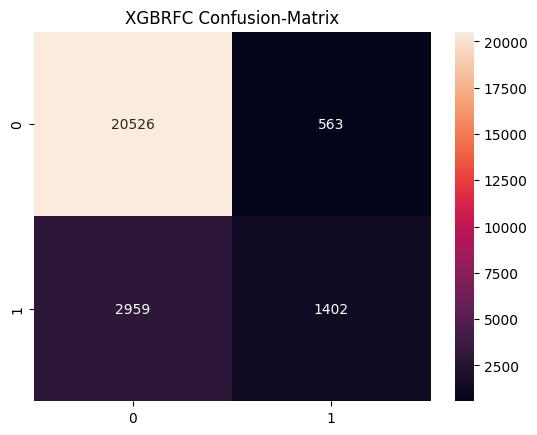

In [16]:
ax = plt.axes()
cm = confusion_matrix(t_test, t_hat)
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
ax.set_title('XGBRFC Confusion-Matrix')
plt.show()

In [17]:
print(time.time()-start_time)

198.93258786201477
